#  Time Series Objective

🎯 Objective: Forecast total sales and number of transactions per store and category.

## Step 1: Import Libraries

In [4]:
import pyodbc
import pandas as pd

## Step 2: Connect to SQL Server Data Warehouse

In [7]:
# SQL Server connection settings (using Windows Authentication)
server = 'localhost'  # e.g., 'localhost' or your server name
database = 'DW_Monoprix'  # Change to your target Data Warehouse
driver = '{ODBC Driver 17 for SQL Server}'

# Create connection string and connect
connection_string = f'DRIVER={driver};SERVER={server};DATABASE={database};Trusted_Connection=yes;'
conn = pyodbc.connect(connection_string)

## Step 3: Query Data from Table

In [10]:
query = """ SELECT 
    DATEPART(YEAR, SalesDate.FullDate) AS Sales_Year, 
    DATEPART(MONTH, SalesDate.FullDate) AS Sales_Month,
    Category.BK_Category AS Category_Name,
    SUM(F.SalesTransactions_Amount) AS Total_Sales
FROM Fact_SalesPerformance F
LEFT JOIN DimDate SalesDate ON F.StTransactionDateID = SalesDate.PK_Date
LEFT JOIN DimCategory Category ON F.CategoryID = Category.PK_Category
WHERE F.SalesTransactions_Amount IS NOT NULL
GROUP BY 
    DATEPART(YEAR, SalesDate.FullDate), 
    DATEPART(MONTH, SalesDate.FullDate), 
    Category.BK_Category
ORDER BY Sales_Year, Sales_Month
 """

# Load the pre-joined data directly from SQL
df = pd.read_sql(query, conn)

df


C:\Users\yasmi\AppData\Local\Temp\ipykernel_10104\3847425728.py:18: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql(query, conn)


,Sales_Year,Sales_Month,Category_Name,Total_Sales
0,2019,7,Céréales et couscous,4560.0
1,2019,7,Épices,3871.0
2,2019,7,Fournitures,1399.0
3,2019,7,Fromage,3107.0
4,2019,7,Pâtes,17358.0
...,...,...,...,...
956,2025,1,Sauces,11044.0
957,2025,1,Sports,12590.0
958,2025,1,Surgelés,3397.0
959,2025,1,Textile,3047.0


## Step 4: Preprocessing and Date Conversion

In [13]:
# Let's select one category for forecasting (e.g., 'Eyewear')
category_to_forecast = 'Pâtes'  

df_cat = df[df['Category_Name'] == category_to_forecast].copy()
df_cat['Date'] = pd.to_datetime(dict(year=df_cat.Sales_Year, month=df_cat.Sales_Month, day=1))
df_cat = df_cat[['Date', 'Total_Sales']].sort_values('Date').reset_index(drop=True)
df_cat.set_index('Date', inplace=True)
df_cat

,Total_Sales
Date,
2019-07-01,17358.0
2019-08-01,66812.0
2019-09-01,82658.0
2019-10-01,84569.0
2019-11-01,108559.0
...,...
2024-09-01,74963.0
2024-10-01,61268.0
2024-11-01,115655.0


## Step 5: Visualization

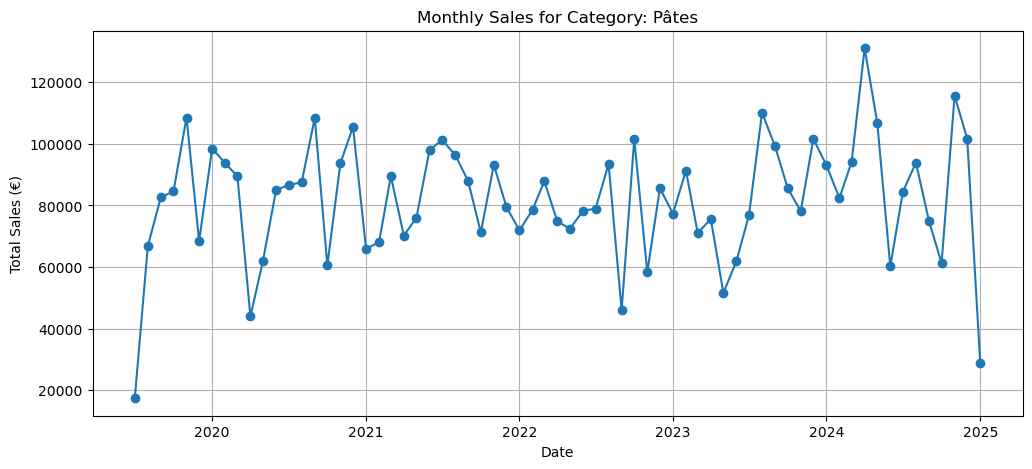

In [16]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 5))
plt.plot(df_cat.index, df_cat['Total_Sales'], marker='o')
plt.title(f"Monthly Sales for Category: {category_to_forecast}")
plt.xlabel("Date")
plt.ylabel("Total Sales (€)")
plt.grid(True)
plt.show()

## Step 6: Train-Test Split

In [19]:
# Forecast the last 6 months
train = df.iloc[:-6]
test = df.iloc[-6:]

## Step 7: SARIMA Model

In [22]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

sarima_model = SARIMAX(train['Total_Sales'],
                       order=(1,1,1),
                       seasonal_order=(1,1,1,12),
                       enforce_stationarity=False,
                       enforce_invertibility=False)
sarima_results = sarima_model.fit()
sarima_forecast = sarima_results.forecast(steps=6)
sarima_forecast.index = test.index

## Step 8: XGBoost Regression Model with Lag Features

In [24]:
import xgboost as xgb
import numpy as np

# Create lag features
def create_features(series, lags=[1, 2, 3]):
    df_feat = pd.DataFrame(index=series.index)
    for lag in lags:
        df_feat[f'lag_{lag}'] = series.shift(lag)
    df_feat['target'] = series
    return df_feat.dropna()

df_lagged = create_features(df['Total_Sales'])
train_lagged = df_lagged.iloc[:-6]
test_lagged = df_lagged.iloc[-6:]

X_train = train_lagged.drop('target', axis=1)
y_train = train_lagged['target']
X_test = test_lagged.drop('target', axis=1)
y_test = test_lagged['target']

xgb_model = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=100)
xgb_model.fit(X_train, y_train)
xgb_forecast = xgb_model.predict(X_test)

## Step 9: Compare Performance

SARIMA - MAE: 11804.34, RMSE: 12363.02
XGBoost - MAE: 15318.54, RMSE: 17632.79


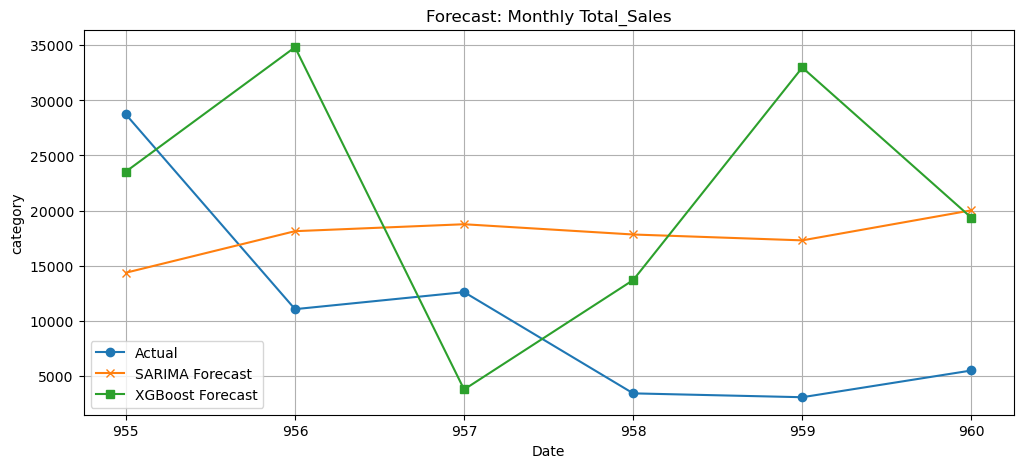

In [43]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

def evaluate(true, pred, label):
    print(f"{label} - MAE: {mean_absolute_error(true, pred):.2f}, RMSE: {np.sqrt(mean_squared_error(true, pred)):.2f}")

evaluate(test['Total_Sales'], sarima_forecast, "SARIMA")
evaluate(y_test, xgb_forecast, "XGBoost")

# Plot comparison
plt.figure(figsize=(12, 5))
plt.plot(test.index, test['Total_Sales'], label='Actual', marker='o')
plt.plot(sarima_forecast, label='SARIMA Forecast', marker='x')
plt.plot(y_test.index, xgb_forecast, label='XGBoost Forecast', marker='s')
plt.title("Forecast: Monthly Total_Sales")
plt.xlabel("Date")
plt.ylabel("category")
plt.legend()
plt.grid(True)
plt.show()

## Step 10: Forecast 5 Future Months with SARIMA

In [45]:
full_model = SARIMAX(df_cat['Total_Sales'],
                     order=(1,1,1),
                     seasonal_order=(1,1,1,12),
                     enforce_stationarity=False,
                     enforce_invertibility=False)

full_results = full_model.fit()
forecast_steps = 5
sarima_future = full_results.forecast(steps=forecast_steps)

last_date = df_cat.index[-1]
future_dates = pd.date_range(start=last_date + pd.DateOffset(months=1), periods=forecast_steps, freq='MS')
sarima_future.index = future_dates

print("SARIMA 5-Month Forecast:")
print(sarima_future)

C:\Users\yasmi\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\yasmi\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


SARIMA 5-Month Forecast:
2025-02-01    84087.285514
2025-03-01    78656.894813
2025-04-01    87662.195504
2025-05-01    87588.041276
2025-06-01    80783.687528
Freq: MS, Name: predicted_mean, dtype: float64


## Step 11: Forecast 5 Future Months with XGBoost

In [47]:
df_full_lags = create_features(df_cat['Total_Sales'])
X_full = df_full_lags.drop('target', axis=1)
y_full = df_full_lags['target']
xgb_model.fit(X_full, y_full)

last_known = df_cat['Total_Sales'].copy().reset_index(drop=True)
future_preds = []

for _ in range(5):
    lags = [last_known.iloc[-i] for i in [1, 2, 3]]
    input_df = pd.DataFrame([lags], columns=['lag_1', 'lag_2', 'lag_3'])
    pred = xgb_model.predict(input_df)[0]
    future_preds.append(pred)
    last_known = pd.concat([last_known, pd.Series([pred])], ignore_index=True)

xgb_future = pd.Series(future_preds, index=future_dates)

print("XGBoost 5-Month Forecast:")
print(xgb_future)

XGBoost 5-Month Forecast:
2025-02-01    76134.859375
2025-03-01    85738.406250
2025-04-01    85623.625000
2025-05-01    93031.835938
2025-06-01    58700.734375
Freq: MS, dtype: float32


## Step 12: Visualize Combined Forecast

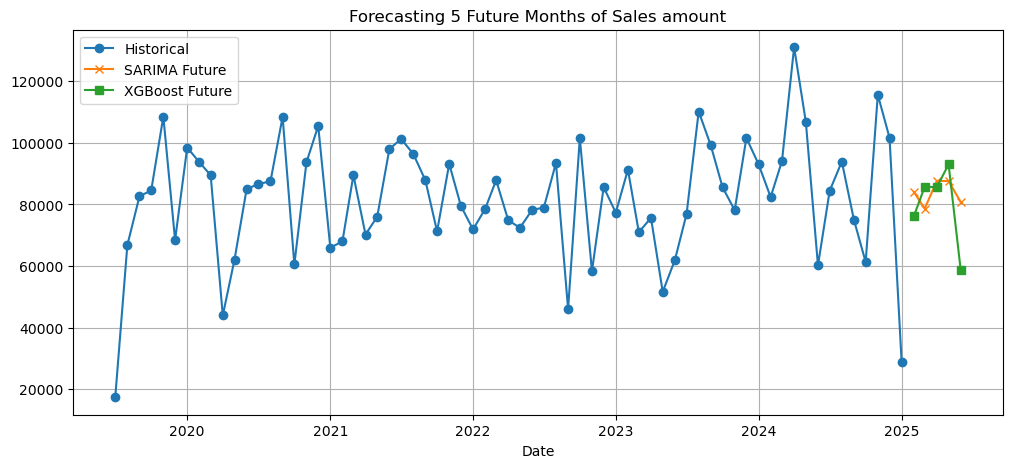

In [59]:
plt.figure(figsize=(12, 5))
plt.plot(df_cat.index, df_cat['Total_Sales'], label='Historical', marker='o')
plt.plot(sarima_future.index, sarima_future, label='SARIMA Future', marker='x')
plt.plot(xgb_future.index, xgb_future, label='XGBoost Future', marker='s')
plt.title("Forecasting 5 Future Months of Sales amount")
plt.xlabel("Date")
plt.ylabel("")
plt.legend()
plt.grid(True)
plt.show()
